# Spotify Podcast Dataset - Publisher



In [4]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np

In [122]:
df = pd.read_csv('../../podcasts-no-audio-13GB-selected/metadata_with_episode_dates.csv')
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d').reset_index(drop=True)

# Dataset is constrained to start_date and end_date
start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2020-03-01")

# Filter the DataFrame to include only rows between start_date and end_date
df = df[(df.release_date >= start_date) & (df.release_date <= end_date)]

In [124]:
df.shape

(87352, 13)

In [123]:
df.columns

Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix',
       'release_date'],
      dtype='object')

# Publisher Specific Insights

In [101]:
df['publisher'].unique()

array(['Katie Houle', 'Morning Cup Of Murder', 'Inside the 18 GK Media',
       ..., 'High Schooler ', 'Zach Valen', 'Chelsea Batalla'],
      dtype=object)

## Publisher Summary Stats

In [102]:
df_ss = df[df['publisher']=='Spotify Studios']

In [103]:
df_ss.shape

(1252, 13)

In [104]:
df_pub_barchart_values = np.array([
    # number of shows
    df_ss['show_filename_prefix'].unique().shape[0],
    # number of total episodes
    df_ss['episode_filename_prefix'].unique().shape[0],
    # average number of episodes per show
    df_ss.groupby('show_filename_prefix').size().mean()
])
bar_chart_row

[47, 1252, 26.638297872340427]

In [105]:
df_pub_barchart_categories = np.array(['number_of_shows', 'number_of_episodes', 'mean_number_of_episodes_per_show'])

In [106]:
cols = ['Category','Values']
df_pub_barchart = pd.DataFrame(np.array([df_pub_barchart_categories, bar_chart_row]).T, columns=cols)
df_pub_barchart

,Category,Values
0,number_of_shows,47
1,number_of_episodes,1252
2,mean_number_of_episodes_per_show,26.638297872340427


In [107]:
df_pub_barchart.dtypes

Category    object
Values      object
dtype: object

In [146]:
# bar chart of number of shows, number of episodes, number of episodes per show
bar_chart = alt.Chart(df_pub_barchart).mark_bar().encode(
    x='Values:Q',  # Quantitative scale for the y-axis
    y=alt.X('Category:N'),
    tooltip=['Values']
).configure_scale(
    bandPaddingInner=0.2,
)

bar_chart = bar_chart.properties(width=300, height=200)
bar_chart.save('publisher_summary_bar_chart.json')
bar_chart

alt.Chart(...)

## Publisher Timeseries Stats

In [118]:
df.columns

Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix',
       'release_date'],
      dtype='object')

In [111]:
df.dtypes

show_uri                           object
show_name                          object
show_description                   object
publisher                          object
language                           object
rss_link                           object
episode_uri                        object
episode_name                       object
episode_description                object
duration                          float64
show_filename_prefix               object
episode_filename_prefix            object
release_date               datetime64[ns]
dtype: object

In [114]:
df['release_date']

0        2019-12-18
1        2020-01-30
2        2019-01-18
3        2019-03-01
4               NaT
            ...    
105355   2019-03-29
105356   2019-05-04
105357   2019-01-08
105358   2019-06-25
105359   2019-10-27
Name: release_date, Length: 105360, dtype: datetime64[ns]

In [125]:
df_ss = df[df['publisher']=='Spotify Studios']

Axes(0.125,0.11;0.775x0.77)


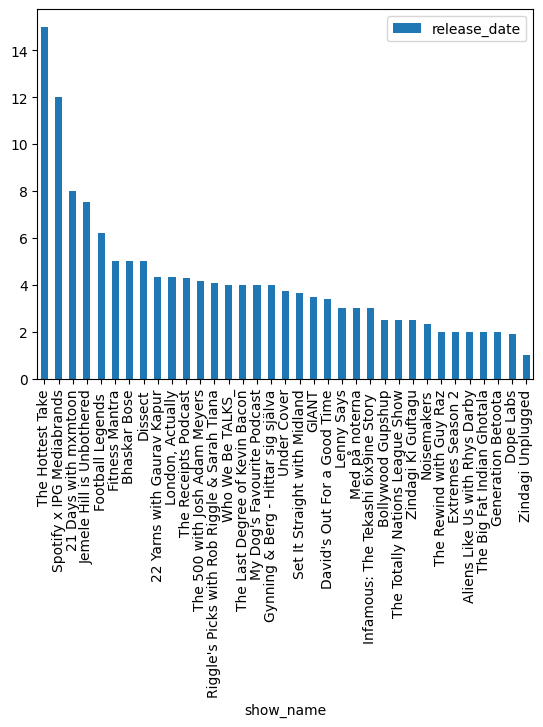

In [145]:
# Resample by month and count the number of rows
monthly_counts = df_ss[['show_name','release_date']].groupby(['show_name',df_ss.release_date.dt.to_period("M")]).agg('count').groupby('show_name').mean().sort_values(by='release_date',ascending=False).plot.bar()

# Reset the index to have 'Date' as a column again
#monthly_counts = monthly_counts.reset_index()

# Rename the columns
#monthly_counts.columns = ['Month', 'Count']

# Display the resulting DataFrame
print(monthly_counts)

In [130]:
monthly_counts.value_counts()

release_date  release_date
2019-01       2019-01-17      4
              2019-01-02      3
              2019-01-24      3
              2019-01-31      3
              2019-01-07      2
                             ..
2020-02       2020-02-25      2
              2020-02-18      2
              2020-02-28      2
              2020-02-04      2
              2020-02-29      1
Name: count, Length: 252, dtype: int64

# General Insights for Publishers

## Find Shows by Publisher

In [6]:
df_pub2show = df.groupby(['publisher','show_name']).size().sort_values(ascending=False).reset_index().groupby('publisher').size().sort_values(ascending=False)
df_pub2show = pd.DataFrame(df_pub2show, columns=['Number of Shows']).reset_index()
# Calculate circle sizes based on 'Value'
#df_pub2show['CircleSize'] = np.sqrt(df_pub2show['Number of Shows'])
df_pub2show['Number of Shows Jitter'] = df_pub2show['Number of Shows'] + np.abs(np.random.normal(0,1,(len(df_pub2show),)))

## Find Episodes by Publisher

In [7]:
df_pub2episode = df.groupby('publisher').size().sort_values(ascending=False)
df_pub2episode = pd.DataFrame(df_pub2episode, columns=['Number of Episodes']).reset_index()
# Calculate circle sizes based on 'Value'
df_pub2episode['CircleSize'] = np.sqrt(df_pub2episode['Number of Episodes'])
df_pub2episode['Number of Episodes Jitter'] = df_pub2episode['Number of Episodes'] + np.random.random((len(df_pub2episode),))
df_pub2episode.shape

(17490, 4)

In [8]:
df_pub = df_pub2episode.merge(df_pub2show,on='publisher',how='left')

In [9]:
import altair as alt
import pandas as pd
import numpy as np

# Create a scatter plot with circles to represent the categorical table
circle_table = alt.Chart(df_pub.sample(5000)).mark_circle().encode(
    x=alt.X('publisher:O', axis=alt.Axis(labels=False, title='')),
    y=alt.Y('Number of Episodes Jitter:Q', scale=alt.Scale(type='log'), axis=alt.Axis(labels=False, title='')),
    size=alt.Size('CircleSize:Q', scale=alt.Scale(range=[5, 2000]), legend=None),  # Adjust size range as needed
    #color=alt.Color('publisher:N', legend=None),
    color=alt.Color(scale=alt.Scale(scheme='blueorange-8')),
    tooltip=['publisher:N', 'Number of Episodes:Q','Number of Shows:Q']  # Add a tooltip with 'Category' and 'Value'
).properties(
    width=700,
    height=700,
    title='Podcast Publishers (Hover Over)'
).configure_title(
    fontSize=16,
    anchor='middle'
).configure_axis(
    grid=False  # Remove gridlines
).configure_axisY(
    ticks=False
)

circle_table

alt.Chart(...)

In [10]:
df.columns

Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix'],
      dtype='object')

In [11]:
min(np.random.normal(0,1,(len(df_pub2show),)))

-3.9641466260912974

In [12]:
df[df['publisher']=='David'].groupby('show_filename_prefix').size()

show_filename_prefix
show_0tdzFF8Qse4UR8pn9ReNL1    1
show_11UVF4OT5CAlvb5sZCsXu0    2
show_1avz49Hd2W7nj2XXb0SQu1    1
show_2b9g1RKvE30BKJDkkui16u    5
show_6V4blubY5N1PfwpZjKMoCI    3
show_7ndWuoDaVWUbdMdtGCr6ab    1
dtype: int64